In [1]:
import sys
if sys.version_info[0] < 3:
	raise Exception("Python 3 not detected.")
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from scipy import io
import pandas as pd
from scipy.stats import multivariate_normal
from sklearn.model_selection import train_test_split

#use random seed 94709
np.random.seed(94709)

1)

In [2]:
def load(filepath):
    data = np.load(filepath)
    train_data = data['training_data']
    train_labels = data['training_labels']
    test_data = data['test_data']

    #flatten data
    train_data = train_data.reshape(train_data.shape[0], -1)
    test_data = test_data.reshape(test_data.shape[0], -1)

    return train_data, train_labels, test_data

def normalize(image):
    #l2 norm each image
    norm = np.linalg.norm(image, axis = 1)[:, np.newaxis]
    return image/norm
        

def fitGaussian(data, labels):
    classes = len(np.unique(labels))

    means = []
    covariances = []

    for digit in range(classes):
        #get the data for points where it is this specific digit
        digitData = data[labels == digit]

        #normalize data
        digitData = normalize(digitData)

        #mean and covariance
        mean = np.mean(digitData, axis = 0)
        covariance = np.cov(digitData, rowvar = False)

        means.append(mean)
        covariances.append(covariance)

    return means, covariances

train_data, train_labels, test_data = load('../data/mnist-data-hw3.npz')

#normalize all data
train_data = normalize(train_data)
test_data = normalize(test_data)

#mean and covariance matrix for each digit class
means, cov = fitGaussian(train_data, train_labels)

2)

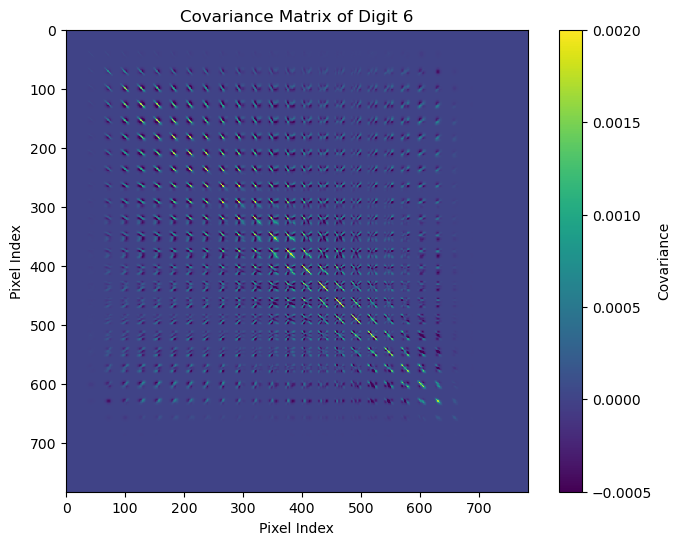

In [3]:
#use digit 6
digit_class = 6

covariance_matrix = cov[digit_class]


plt.figure(figsize = (8,6))
plt.imshow(covariance_matrix, interpolation = 'nearest', vmin = '-0.0005', vmax = '0.0020')
plt.colorbar(label = 'Covariance')
plt.title('Covariance Matrix of Digit 6')
plt.xlabel('Pixel Index')
plt.ylabel('Pixel Index')
plt.show()

I visualized the covariance matrix  of the digit 6 using a heatmap. It is clear that the values along the diagonals are far greater in magnitude and more positive than the off-diagonal terms. The much higher values along the diagonal indicates that the pixel values vary more significantly across the data set than within a single pixel since the diagonals are the variances of each pixel; a higher value indicates more perfect correlation with itself. However, the off diagonals indicate slightly less correlation. However, the higher values along the values close to the diagonal indicate a sort of spatial relation between pixels, indicating that values along the diagonal tend to move together, values further away from the diagonal have little to no correlation. I conclude that the focus of the classifer will be along the relationships between the pixels along the diagonal of the heatmap, or in terms of the overall images themselves, neighboring pixels. These correlations will help determine if the digit is a 6 or some other digit, indicating that spatial proximity of pixels is a key component to classification. 

3)

a)


Sample Size: 100 ----- Validation Error: 0.31889999999999996
Sample Size: 200 ----- Validation Error: 0.28759999999999997
Sample Size: 500 ----- Validation Error: 0.6388
Sample Size: 1000 ----- Validation Error: 0.32699999999999996
Sample Size: 2000 ----- Validation Error: 0.19999999999999996
Sample Size: 5000 ----- Validation Error: 0.15090000000000003
Sample Size: 10000 ----- Validation Error: 0.1331
Sample Size: 30000 ----- Validation Error: 0.12150000000000005
Sample Size: 50000 ----- Validation Error: 0.12150000000000005


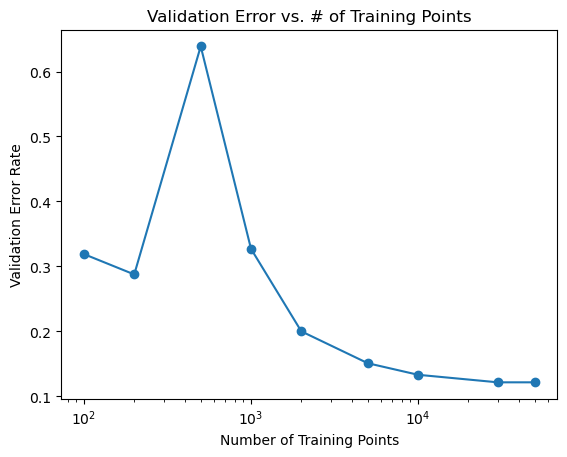

In [4]:
class_counts = np.bincount(train_labels)

pooled_cov = np.mean(cov, axis = 0) #from lecture 9, this is just 1/n times the sum of all covariance matrices

priors = class_counts/sum(class_counts)

def lda(x, means, pooled_cov, priors):
    priors = priors[:, np.newaxis]
    gaussians = []
    for mean in means:
        gaussians.append(multivariate_normal(mean, pooled_cov, allow_singular = True))
    #evaluate the logpdf of the gaussians at each of the sample points
    #log pdf already includes tboth terms of the discriminant function wihtout the priors
    discriminants = np.array([discriminant.logpdf(x) for discriminant in gaussians])
    #add the priors
    discriminants = discriminants + np.log(priors)
    return discriminants.argmax(axis = 0)

#split into 10,000 pts for validation, rest for training
#allowed to use sklearn FOR THIS PART ONLY
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 10000, random_state = 94709)

#write a error function
def error(predicted, actual):
    return 1 - np.mean(predicted == actual)

def randomSample(trainData, trainLabels, size):
    train_indices = np.random.choice(len(trainData), size = size, replace = False)
    trainSamples = trainData[train_indices]
    labelSamples = trainLabels[train_indices]
    return trainSamples, labelSamples

#classify
training_points_count = [100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]
LDAerrors = []

for size in training_points_count:
    #get random samples of each size, get the sample mean and cov matrices
    trainDataSamples, trainDataLabels = randomSample(train_data, train_labels, size)
    sampleMean, sampleCov = fitGaussian(trainDataSamples, trainDataLabels)
    
    #get priors
    sampleClassCounts = np.bincount(trainDataLabels)
    samplePriors = sampleClassCounts/sum(sampleClassCounts)

    #compute pooled sample covariance matrix
    samplePooledCov = np.mean(sampleCov, axis = 0)

    #classify
    # predicted = []
    # for i in val_data:
    #     predicted.append(lda(i, sampleMean, samplePooledCov, samplePriors))
    predicted = lda(val_data, sampleMean, samplePooledCov, samplePriors)
    
    thisError = error(predicted, val_labels)
    LDAerrors.append(thisError)

    print(f'Sample Size: {size} ----- Validation Error: {thisError}')

plt.plot(training_points_count, LDAerrors, marker = 'o')
plt.xlabel('Number of Training Points')
plt.ylabel('Validation Error Rate')
plt.title('Validation Error vs. # of Training Points')
plt.xscale('log')
plt.show()

b)

Sample Size: 100 ----- Validation Error: 0.8674999999999999
Sample Size: 200 ----- Validation Error: 0.8552
Sample Size: 500 ----- Validation Error: 0.5121
Sample Size: 1000 ----- Validation Error: 0.27949999999999997
Sample Size: 2000 ----- Validation Error: 0.268
Sample Size: 5000 ----- Validation Error: 0.2932
Sample Size: 10000 ----- Validation Error: 0.24019999999999997
Sample Size: 30000 ----- Validation Error: 0.1683
Sample Size: 50000 ----- Validation Error: 0.16300000000000003


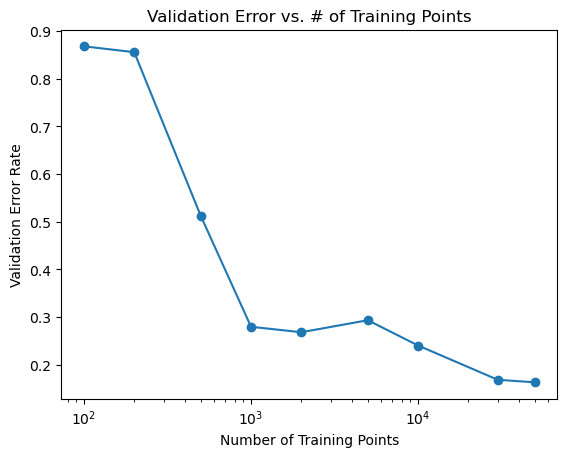

In [5]:
def qda(x, means, covs, priors):
    priors = priors[:, np.newaxis]
    gaussians = []
    for mean, cov in zip(means, covs):
        gaussians.append(multivariate_normal(mean, cov, allow_singular = True))
    #evaluate the logpdf of the gaussians at each of the sample points
    discriminants = np.array([discriminant.logpdf(x) for discriminant in gaussians])
    #add the priors
    discriminants = discriminants + np.log(priors)
    return discriminants.argmax(axis = 0)

#classify
training_points_count = [100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]
QDAerrors = []

for size in training_points_count:
    #get random samples of each size, get the sample mean and cov matrices
    trainDataSamples, trainDataLabels = randomSample(train_data, train_labels, size)
    sampleMean, sampleCov = fitGaussian(trainDataSamples, trainDataLabels)
    
    #get priors
    sampleClassCounts = np.bincount(trainDataLabels)
    samplePriors = sampleClassCounts/sum(sampleClassCounts)

    #classify
    # predicted = []
    # for i in val_data:
    #     predicted.append(lda(i, sampleMean, samplePooledCov, samplePriors))
    predicted = qda(val_data, sampleMean, sampleCov, samplePriors)
    
    thisError = error(predicted, val_labels)
    QDAerrors.append(thisError)

    print(f'Sample Size: {size} ----- Validation Error: {thisError}')

plt.plot(training_points_count, QDAerrors, marker = 'o')
plt.xlabel('Number of Training Points')
plt.ylabel('Validation Error Rate')
plt.title('Validation Error vs. # of Training Points')
plt.xscale('log')
plt.show()

c) It appears that LDA performed better on the dataset, attaining a validation error of about 12% while QDA stayed at an error of about 16% when we use 50,000 training points. This may be because the size of the dataset is relatively small; with QDA, the nonlinear decision boundaries would lead to overfitting from the increased number of parameters (or covariance matrices), causing worse performance on the validation set. Each class of digits may also have similar covariance matrices, which would certainly explain the similar heatmaps across all digit classes for their respective covariance matrices. 

d)


In [6]:
LDAerrors = []
QDAerrors = []
def digitError(predicted, actual):
    errors = []
    for digit in range(0, 10):
        digit_predicted = predicted[actual == digit]
        digit_actual = actual[actual == digit]

        misclassified = (digit_predicted != digit_actual).sum()
        errors.append(misclassified / len(digit_actual))
    return errors


for size in training_points_count:
    #get random samples of each size, get the sample mean and cov matrices
    trainDataSamples, trainDataLabels = randomSample(train_data, train_labels, size)
    sampleMean, sampleCov = fitGaussian(trainDataSamples, trainDataLabels)
    
    #get priors
    sampleClassCounts = np.bincount(trainDataLabels)
    samplePriors = sampleClassCounts/sum(sampleClassCounts)

    #compute pooled sample covariance matrix
    samplePooledCov = np.mean(sampleCov, axis = 0)
    
    #classify
    QDApredicted = qda(val_data, sampleMean, sampleCov, samplePriors)
    LDApredicted = lda(val_data, sampleMean, samplePooledCov, samplePriors)
    
    QDAerror = np.array(digitError(QDApredicted, val_labels))
    LDAerror = np.array(digitError(LDApredicted, val_labels))
    
    QDAerrors.append(QDAerror)
    LDAerrors.append(LDAerror)

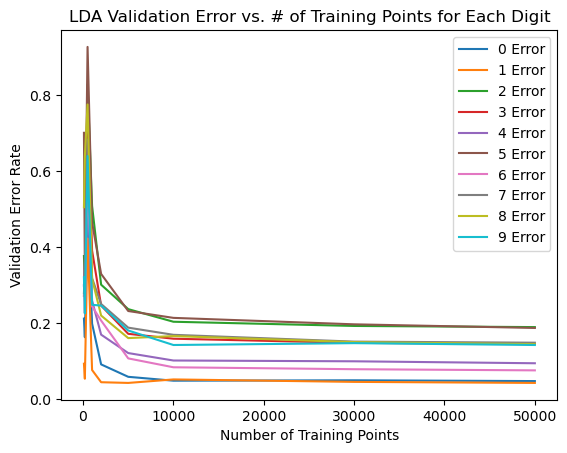

In [7]:
def plot_val_digit_error(errors, training_points_count, type):
    digits = range(10)
    errors = np.array(errors).T
    for digit, error in zip(digits, errors):
        plt.plot(training_points_count, error, label = f'{digit} Error')
    plt.xlabel('Number of Training Points')
    plt.ylabel('Validation Error Rate')
    plt.title(f'{type} Validation Error vs. # of Training Points for Each Digit')
    plt.legend()
    plt.show

plot_val_digit_error(LDAerrors, training_points_count, 'LDA')

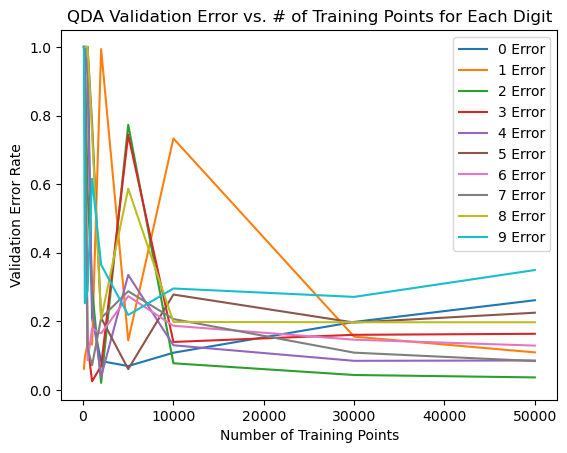

In [8]:
plot_val_digit_error(QDAerrors, training_points_count, 'QDA')

From my graph, it appears that 1 is the easest digit to classify for LDA, yielding the smallest error after we hit 30,000 training points. This is probably because 1 has the most simple and distinct shape, making all instances of the 1 digit pretty similar. All of the data will look approximately the same with little variation: a line with higher pixel values in the middle region, followed by 0 pixel values all around it. Furthermore, the straight, single vertical line makes it less likely to confuse it with another digit. However for QDA, the easiest digit to classify was 2. This may be because of the fact that the quadratic decision boundary is not lineary, and could more easily fit to the shape of '2' digits. It is also likely that 2's are drawn the most similar out of all the images and all individual samples have a similar variance between different pixels.

4)

In [9]:
from sklearn.decomposition import PCA

train_data, train_labels, test_data = load('../data/mnist-data-hw3.npz')

#use PCA to reduce dimensionality, original = 784 features
components = 65
pca = PCA(n_components = components)

pca.fit(train_data)

train_data = pca.transform(train_data)
test_data = pca.transform(test_data)

train_data = normalize(train_data)
test_data = normalize(test_data)

train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 10000, random_state = 94709)

trainDataSamples, trainDataLabels = train_data, train_labels
#normalize all data
#fit gaussian
sampleMean, sampleCov = fitGaussian(trainDataSamples, trainDataLabels)
    
#get priors
sampleClassCounts = np.bincount(trainDataLabels)
samplePriors = sampleClassCounts/sum(sampleClassCounts)

#compute pooled sample covariance matrix
samplePooledCov = np.mean(sampleCov, axis = 0)


#classify
# predicted = []
# for i in val_data:
# predicted.append(lda(i, sampleMean, samplePooledCov, samplePriors))
Lpredicted = lda(val_data, sampleMean, samplePooledCov, samplePriors)
Qpredicted = qda(val_data, sampleMean, sampleCov, samplePriors)
    
Lerror = error(Lpredicted, val_labels)
Qerror = error(Qpredicted, val_labels)


print(f'LDA ----- Validation Error: {Lerror}')
print(f'QDA ----- Validation Error: {Qerror}')


testPred = qda(test_data, sampleMean, sampleCov, samplePriors)
indices = [x for x in range(1, len(testPred) + 1)]
df = pd.DataFrame({'Id': indices, 'Category': testPred})
df.to_csv('mnistPredictions.csv', index = False, sep = ',')


LDA ----- Validation Error: 0.12350000000000005
QDA ----- Validation Error: 0.041200000000000014


My Kaggle username is StephenLiu2004. My best Kaggle score was 0.958

Tweaks: I experimented with PCA, with which QDA yields much better results when we focus on fewer principal components (less overfitting). Best number of components was 65. 

5)

In [10]:
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA

def spfitGaussian(data, labels):
    
    classes = len(np.unique(labels))

    means = []
    covariances = []

    for digit in range(classes):
        #get the data for points where it is this specific digit
        digitData = data[labels == digit]

        #normalize data
        # digitData = normalize(digitData)

        #mean and covariance
        mean = np.mean(digitData, axis = 0)
        covariance = np.cov(digitData, rowvar = False)

        means.append(mean)
        covariances.append(covariance)

    return means, covariances

# def spfitGaussian(data, labels):
#     classes = len(np.unique(labels))
#     means = []
#     covariances = []
#     data = np.array(data)
#     for digit in range(classes):
#         #get the data for points where it is this specific digit
#         mask = np.array([i == digit for i in labels])
#         digitData = data[mask]
#         #mean and covariance
#         digitData = normalize(digitData)

#         mean = np.mean(digitData, axis = 0)
#         covariance = np.cov(digitData, rowvar = False)

#         means.append(mean)
#         covariances.append(covariance)

#     return means, covariances

# ham_dir = "../data/ham"
# spam_dir = "../data/spam"
# test_dir = "../data/test"

# def read_files(dir):
#     texts = []
#     for file in os.listdir(dir):
#         with open(os.path.join(dir, file), 'r', encoding = 'utf-8') as file:
#             text = file.read()
#             texts.append(text)
#     return texts

#ham and spam files
# ham_texts = read_files(ham_dir)
# spam_texts = read_files(spam_dir)
# test_texts = read_files(test_dir)

# sptrain_data = ham_texts + spam_texts
# sptrain_labels = [int(0) for i in range(len(ham_texts))] + [int(1) for j in range(len(spam_texts))]

# vectorizer = CountVectorizer()

# vectorizer.fit(sptrain_data)

# sptrain_data = vectorizer.transform(sptrain_data)
# sptest_data = vectorizer.transform(test_texts)

# sptrain_data = sptrain_data.toarray()
# sptest_data = sptest_data.toarray()

# sptrain_data = np.array(sptrain_data)
# sptest_data = np.array(sptest_data)

# sptrain_data = sptrain_data.reshape(sptrain_data.shape[0], -1)
# sptest_data = sptest_data.reshape(sptest_data.shape[0], -1)



sptrain_data, sptrain_labels, sptest_data = load('../data/spam-data-hw3.npz')

#use PCA to reduce dimensionality
components = 48
pca = PCA(n_components = components)

pca.fit(sptrain_data)

sptrain_data = pca.transform(sptrain_data)
sptest_data = pca.transform(sptest_data)

sptrain_data, spval_data, sptrain_labels, spval_labels = train_test_split(sptrain_data, sptrain_labels, test_size = np.round(0.10 * len(sptrain_data)).astype(int), random_state = 94709)
# sptrain_data, spval_data, sptrain_labels, spval_labels = train_test_split(sptrain_data, sptrain_labels, test_size = 0.1, random_state = 94709)


#trainDataSamples, trainDataLabels = randomSample(sptrain_data, sptrain_labels, np.round(0.90 * len(sptrain_data)).astype(int))
trainDataSamples, trainDataLabels = sptrain_data, sptrain_labels

sampleMean, sampleCov = spfitGaussian(trainDataSamples, trainDataLabels)
    
#get priors
sampleClassCounts = np.bincount(trainDataLabels)
samplePriors = sampleClassCounts/sum(sampleClassCounts)

#compute pooled sample covariance matrix
samplePooledCov = np.mean(sampleCov, axis = 0)

#classify
# predicted = []
# for i in val_data:
# predicted.append(lda(i, sampleMean, samplePooledCov, samplePriors))

LDApredicted = lda(spval_data, sampleMean, samplePooledCov, samplePriors)
QDApredicted = qda(spval_data, sampleMean, sampleCov, samplePriors)    

LDAerror = error(LDApredicted, spval_labels)
QDAerror = error(QDApredicted, spval_labels)


#LDA has significantly better performance
print(f'Type: QDA ----- Validation Error: {QDAerror}')
print(f'Type: LDA ----- Validation Error: {LDAerror}')

testPred = qda(sptest_data, sampleMean, sampleCov, samplePriors)
indices = [x for x in range(1, len(testPred) + 1)]
df = pd.DataFrame({'Id': indices, 'Category': testPred})
df.to_csv('spamPredictions.csv', index = False, sep = ',')


Type: QDA ----- Validation Error: 0.16306954436450838
Type: LDA ----- Validation Error: 0.18705035971223016


My Kaggle username is StephenLiu2004. My best Kaggle score was 0.836

Tweaks: I experimented with a bag-of-words model, but it did not yield promising test-data accuracy. I then experimented with PCA, and was able to bring up the accuracy by about 3% on the test data set using 48 principal components. I also feature engineered, similar to HW1. Because of these tweaks, the nonlinear nature of QDA's decision boundary actually worked better than LDA. 